<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore HDB Resale Price Predictions

--- 
**Primary Learning Objectives:**
1. Creating and iteratively refining a regression model
2. Using [Kaggle](https://www.kaggle.com/) to practice the modeling process
3. Providing business insights through reporting and presentation.

---

## Contents:
- [Data and Preprocessor Import](#Data_and_Preprocessor_Import)
- [Production Model Construction](#Production_Model_Construction)
- [Key Findings](#Key_Findings)
- [Conclusion and Recommendations](#Conclusion_and_Recommendation)

In [1]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

## Data and Preprocessor Import

In [2]:
# import clean data
X = pd.read_csv('../datasets/X.csv', index_col='Unnamed: 0')
y = pd.read_csv('../datasets/y.csv', index_col='Unnamed: 0').squeeze()

In [3]:
# define folder path for models
folder_path = '../models/'

In [4]:
# load preprocessors
preprocessor_B = dill.load(open(folder_path + 'preprocessor_B.sav', 'rb'))
preprocessor_C = dill.load(open(folder_path + 'preprocessor_C.sav', 'rb'))

In [5]:
# load regression transformer
lr_log_model = dill.load(open(folder_path + 'lr_log.sav', 'rb'))

## Production Model Construction
We will fit the production model on the full dataset without splitting it into train and test

In [6]:
# fit model on full dataset
model_production = Pipeline(
    steps=[
        ('preproc', preprocessor_B),
        ('regr', LinearRegression())
    ]
)

model_production.fit(X, y)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['planning_area',
                                                   'full_flat_type']),
                                                 ('imp', KNNImputer(),
                                                  ['mall_nearest_distance']),
                                                 ('dummy',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7f95b9ed3c70>),
                                                  ['hdb_age', 'mid',
                                                   'floor_area_sqft',
                                                   'tranc_year', 'tranc_month',
                                                   'hawker_nearest_distance',
                                                   'hawker_within_2km',
                                                   'mrt_nearest_distance',
                                                   'bus_interchange',
                                                   'mrt_interchange'])],
                                   verbose_feature_names_out=False)),
                ('regr', LinearRegression())])

## Evaluate Production Model

In [7]:
# generate RMSE metric
y_pred = model_production.predict(X)

print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred))}')

RMSE: 49186.67525313379


## Export Production Model

In [8]:
dill.dump(model_production, open('../models/model_production.sav', 'wb'))

## Key Findings

In [9]:
model_production['preproc'].get_feature_names_out()

array(['planning_area_Bedok', 'planning_area_Bishan',
       'planning_area_Bukit Batok', 'planning_area_Bukit Merah',
       'planning_area_Bukit Panjang', 'planning_area_Bukit Timah',
       'planning_area_Changi', 'planning_area_Choa Chu Kang',
       'planning_area_Clementi', 'planning_area_Downtown Core',
       'planning_area_Geylang', 'planning_area_Hougang',
       'planning_area_Jurong East', 'planning_area_Jurong West',
       'planning_area_Kallang', 'planning_area_Marine Parade',
       'planning_area_Novena', 'planning_area_Outram',
       'planning_area_Pasir Ris', 'planning_area_Punggol',
       'planning_area_Queenstown', 'planning_area_Rochor',
       'planning_area_Sembawang', 'planning_area_Sengkang',
       'planning_area_Serangoon', 'planning_area_Tampines',
       'planning_area_Tanglin', 'planning_area_Toa Payoh',
       'planning_area_Western Water Catchment', 'planning_area_Woodlands',
       'planning_area_Yishun', 'full_flat_type_2 ROOM 2-room',
       'full_

In [10]:
# examine coefficients of predictor variables
model_coef = pd.DataFrame(model_production['regr'].coef_.transpose(), 
                          index=model_production['preproc'].get_feature_names_out(),
                          columns=['coefficient']
                         )

model_coef.reset_index(inplace=True)
model_coef.rename(columns={'index':'variable'}, inplace=True)
model_coef.sort_values(by='coefficient', ascending=False, inplace=True)

In [11]:
# categorise the variables for easier interpretation
model_coef['category'] = [
    'full_flat_type' if 'full_flat_type' in var
    else 'planning_area' if 'planning_area' in var
    else 'mrt' if ('mrt' in var) | ('bus' in var)
    else 'hawker' if 'hawker' in var
    else 'storey' if var == 'mid'
    else 'mall' if 'mall' in var
    else 'time' if 'tranc' in var
    else var
    for var in model_coef['variable']
]

In [12]:
# check out the categories of variables
set(model_coef['category'])

{'floor_area_sqft',
 'full_flat_type',
 'hawker',
 'hdb_age',
 'mall',
 'mrt',
 'planning_area',
 'storey',
 'time'}

#### Variables with largest influence on resale price

In [13]:
# Top 5 and Bottom 5 coefficients
model_coef

,variable,coefficient,category
44,full_flat_type_3 ROOM Terrace,443943.851261,full_flat_type
55,full_flat_type_4 ROOM Terrace,440329.100668,full_flat_type
66,full_flat_type_5 ROOM Type S2,291350.260894,full_flat_type
60,full_flat_type_5 ROOM Improved-Maisonette,253164.130436,full_flat_type
58,full_flat_type_5 ROOM DBSS,237280.617134,full_flat_type
...,...,...,...
13,planning_area_Jurong West,-61905.656324,planning_area
4,planning_area_Bukit Panjang,-67618.593124,planning_area
7,planning_area_Choa Chu Kang,-70206.987201,planning_area
29,planning_area_Woodlands,-108439.021269,planning_area


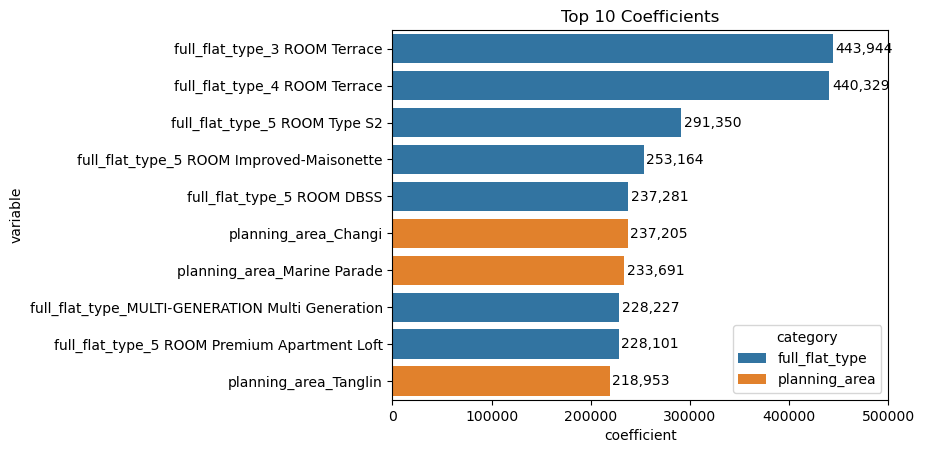

In [14]:
# bar plot of top 10 variables by coefficient and coloured by category 

model_coef_top10 = model_coef[:10]

ax = sns.barplot(model_coef_top10, 
            x='coefficient', 
            y='variable',
            hue='category',
            dodge=False
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);

Observation:
- 7 out of 10 predicator variables are related to full_flat_type. This reflects that the inherent features related to the flat type more likely to increase resale price.
- For instance, Terrace HDB has resale prices that is more than \$400k higher than the base flat type of 1 ROOM Improved HDB.
- Beyond flat type, planning area (i.e. Marine Parade/Changi/Tanglin) related variables have large impact on price (+$230k compared to Ang Mo Kio (base of comparison)).

#### Flat type

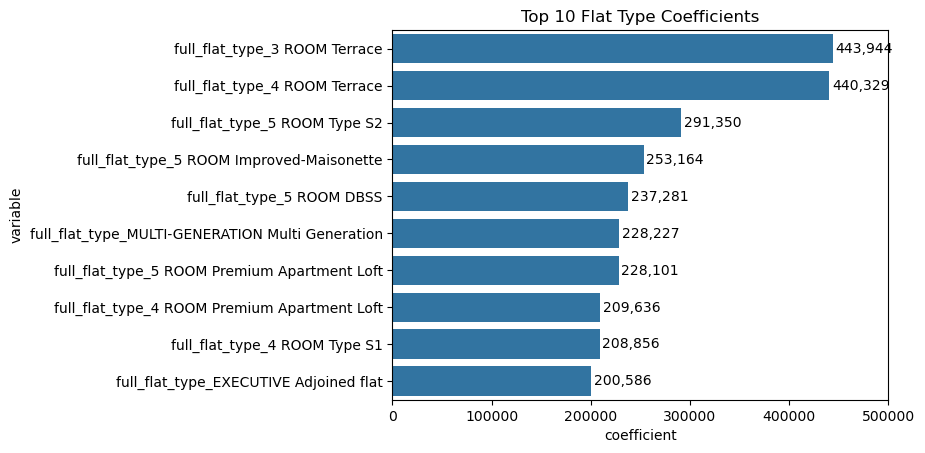

In [15]:
# bar plot of top 10 flat type variables by coefficient and coloured by category 

model_coef_top10 = model_coef[model_coef['category'] == 'full_flat_type'][:10]

ax = sns.barplot(data=model_coef_top10, 
            x='coefficient', 
            y='variable',
            #hue='category',
            color='C0'
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Flat Type Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);


Observations:
- In terms of flat types, maisonette have the greatest positive impact on resale price. To a lesser extent does the number of room matter.

#### Planning Area

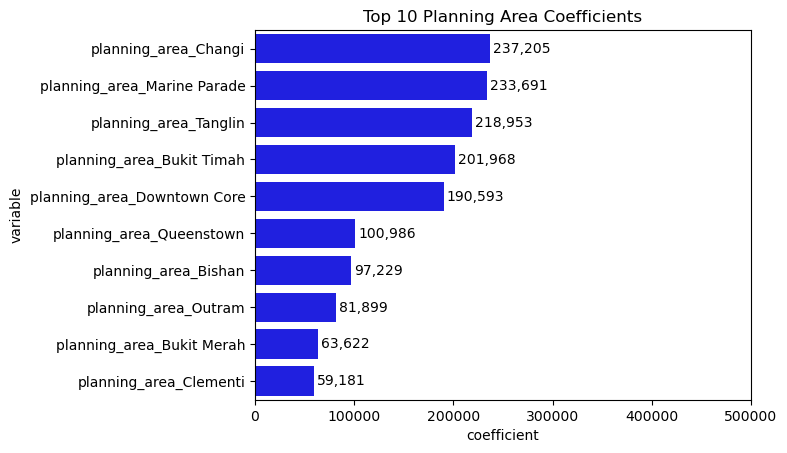

In [16]:
# bar plot of top 10 planning area variables by coefficient and coloured by category 

model_coef_top10 = model_coef[model_coef['category'] == 'planning_area'][:10]

ax = sns.barplot(data=model_coef_top10, 
            x='coefficient', 
            y='variable',
            #hue='category',
            color='b'     
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Top 10 Planning Area Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([0,500000]);


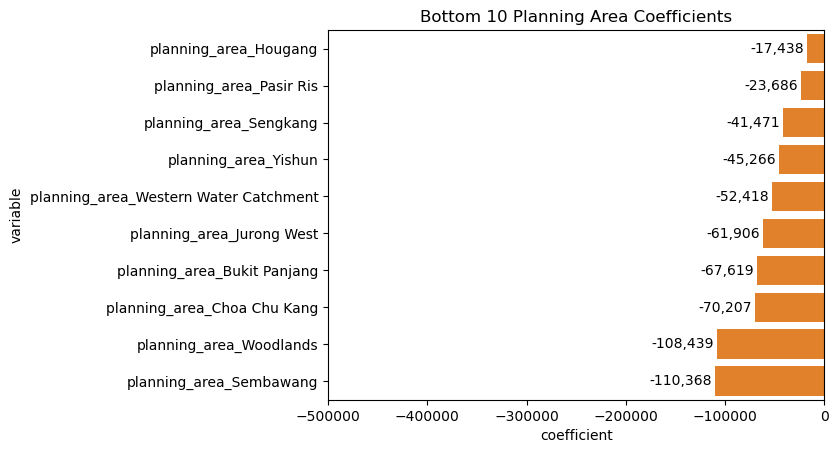

In [17]:
# bar plot of bottom 10 planning area variables by coefficient and coloured by category 
# (whether absolute value is taken is not important since the smallest negative coefficient is -0.2)
model_coef_top10 = model_coef[model_coef['category'] == 'planning_area'][-10:]

ax = sns.barplot(data=model_coef[model_coef['category'] == 'planning_area'].tail(10), 
                 x='coefficient', 
                 y='variable',
                 color='C1')

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2)
    
# add title
ax.set_title('Bottom 10 Planning Area Coefficients')

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,0]);

Observations:
- HDBs in Changi, Marine Parade and Tanglin are more likely to observe higher resale prices compare to Ang Mo Kio (more than \\$200k)
- At the other end of the spectrum, Woodlands & Sembawang were less lucrative (reduction in resale price by more than \\$100k

#### Amenities

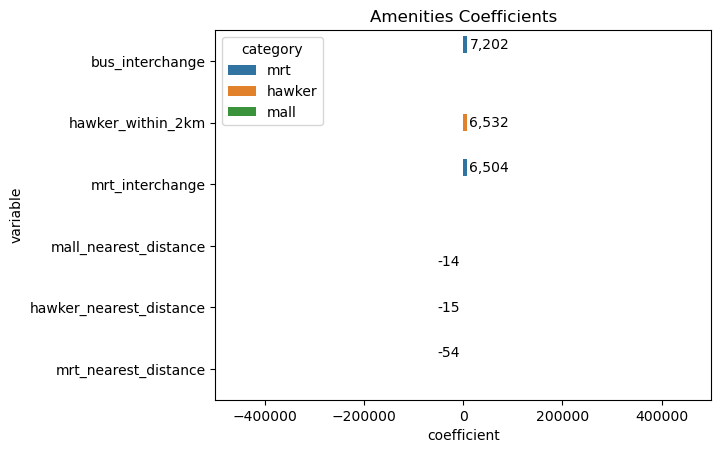

In [18]:
# bar plot of amenities related variables by coefficient and coloured by category 

model_coef_amenities = model_coef[(model_coef['category'] == 'mrt') | (model_coef['category'] == 'mall') | (model_coef['category'] == 'hawker')]

ax = sns.barplot(data=model_coef_amenities, 
            x='coefficient', 
            y='variable',
            hue='category',
            orient='h'
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Amenities Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,500000]);

Observation:
- Effect of amenities on resale price is marginal (<$7k)
- Interestingly, distance to amenities has neglible effect on resale price

#### Other variables

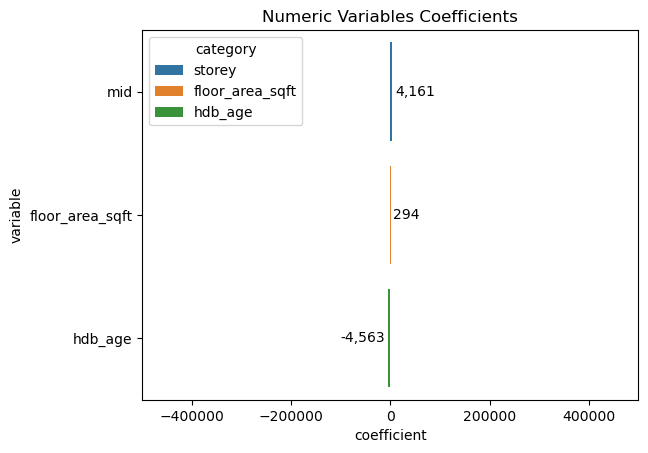

In [19]:
# bar plot of other variables related variables by coefficient and coloured by category 

model_coef_others = model_coef[(model_coef['category'] == 'floor_area_sqft') | (model_coef['category'] == 'hdb_age') | (model_coef['category'] == 'storey')]

ax = sns.barplot(data=model_coef_others, 
            x='coefficient', 
            y='variable',
            hue='category',
            dodge=False
           )

# add data labels
for category in ax.containers:
    ax.bar_label(category, labels=[f'{x:,.0f}' for x in category.datavalues], padding=2);
    
# add title
ax.set_title('Numeric Variables Coefficients');

# set xlim to avoid clipping the data labels
ax.set_xlim([-500000,500000]);

Observations:
- Every 100 sqft increase in the size of the flat, resale price increase by \\$29.6k.
- Every 10 floors increase in storey of the flat, resale price increases by \\$41.6k
- Every 10 years increase in age of the flat, resale prcice decreases by \\$45.6k

## Conclusion and Recommendations

- Key factors determining resale price:
  1. **Location**: Marine Parade, Tanglin or Changi can fetch a much higher resale price than other areas, while those in Woodlands and Sembawang are expected to see the lowest prices.

  2. **Full Flat Type**: Resale prices generally increases with larger number of rooms, in addition flat types such as masionette/terrace fetch higher resale price.

  3. **Flat Size**: For every 100 sqft increase, resale price increases by $29.6k

  4. **Flat Storey**: For every 10 floors increase, resale price increases by $41.6k

  5. **HDB Age**: For every 10 years increase in age of the flat, resale price decreases by about $46k.

- Other considerations:
  1. **Present Value for Resale Price**: This study assumes that Resale Prices provided are already in present value. If otherwise, for future studies, we could explore factoring a compound average annual rate of inflation of 1.2%.

  2. **Other inangible aspects to consider**: Availability/ Proximity to green spaces and community spaces, etc. 